In [1]:
### Tensorflow version 1.x needed ###

import os
import keras
import tensorflow as tf
import numpy as np
from image_data_module import TrainTestData
from salience_prediction_module import SaliencePrediction
import innvestigate
import innvestigate.utils

os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

Using TensorFlow backend.


In [2]:
### MODEL HAS TO BE CONVERTED FROM tf.keras TO PURE keras FOR XAI INVESTIGATION ###

model_path = "nn_models/vgg19_reg_0.h5"
tf_model = tf.keras.models.load_model(model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
keras_model = keras.models.Sequential()
for layer in keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(298, 224, 3)).layers:
    keras_model.add(layer)
keras_model.add(keras.layers.Flatten())
keras_model.add(keras.layers.Dense(256, activation='relu'))
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(1, activation="linear"))

for layer_idx, layer in enumerate(tf_model.layers):
    weights = layer.get_weights()
    keras_model.layers[layer_idx].set_weights(weights)

In [5]:
keras_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.000005),
                    loss='mean_absolute_error',
                    metrics=['mse', 'mae', 'mape'])

In [13]:
data_module = TrainTestData()
prediction_module = SaliencePrediction()

(X_train, Y_train), (X_test, Y_test) = data_module.get_train_test_salience(cv_name=str(0))
(X_train, Y_train), (X_test, Y_test) = prediction_module.scale_data(X_train, Y_train, X_test, Y_test, labels='regression')

predictions = keras_model.predict(X_test)

for idx, val in enumerate(list(Y_test)):
    diff = abs(val-predictions[idx][0])
    print(idx, round(val, 2), round(predictions[idx][0], 2), round(diff, 2))

# 110, 152
worst_idx = [110, 152, 241]
# 0, 9
best_idx = [0, 9, 30, 102, 112, 212]

0 0.73 0.73 0.0
1 0.39 0.45 0.05
2 0.52 0.6 0.08
3 0.66 0.56 0.1
4 0.49 0.53 0.04
5 0.79 0.71 0.08
6 0.39 0.59 0.2
7 0.58 0.48 0.1
8 0.53 0.49 0.04
9 0.67 0.67 0.0
10 0.61 0.54 0.07
11 0.74 0.54 0.2
12 0.44 0.53 0.09
13 0.55 0.51 0.03
14 0.44 0.57 0.13
15 0.44 0.47 0.03
16 0.5 0.61 0.11
17 0.55 0.54 0.01
18 0.67 0.56 0.11
19 0.47 0.69 0.22
20 0.61 0.53 0.08
21 0.62 0.56 0.06
22 0.68 0.55 0.13
23 0.64 0.64 0.01
24 0.67 0.65 0.02
25 0.64 0.62 0.02
26 0.44 0.51 0.08
27 0.43 0.65 0.22
28 0.67 0.59 0.07
29 0.58 0.57 0.02
30 0.58 0.57 0.0
31 0.43 0.61 0.18
32 0.53 0.37 0.16
33 0.59 0.51 0.08
34 0.39 0.53 0.14
35 0.65 0.49 0.17
36 0.58 0.64 0.07
37 0.39 0.35 0.04
38 0.5 0.61 0.11
39 0.47 0.61 0.14
40 0.5 0.57 0.07
41 0.49 0.48 0.01
42 0.5 0.65 0.15
43 0.79 0.49 0.3
44 0.59 0.56 0.03
45 0.58 0.5 0.07
46 0.59 0.61 0.02
47 0.74 0.65 0.09
48 0.58 0.68 0.1
49 0.54 0.66 0.12
50 0.56 0.5 0.06
51 0.64 0.54 0.11
52 0.43 0.57 0.15
53 0.59 0.58 0.01
54 0.53 0.53 0.01
55 0.63 0.59 0.04
56 0.54 0.51 0.03


In [18]:
(ims_train, ims_test) = data_module.get_train_test_image_ids()

(X_train, Y_train), (X_test, Y_test) = data_module.get_train_test_salience(cv_name=str(0))
(X_train, Y_train), (X_test, Y_test) = prediction_module.scale_data(X_train, Y_train, X_test, Y_test, labels='regression')

# 0, 9, 110, 152
relevant_ims = ["15.6.1.jpeg", "15.6.2.jpeg", "9.9.1.jpeg", "9.9.3.jpeg",
                "12.19.1.jpeg", "12.19.3.jpeg", "15.22.1.jpeg", "15.22.3.jpeg"]
for im_idx, im in enumerate(ims_test):
    if im in relevant_ims:
        print(im_idx, im)

28 9.9.1.jpeg
43 12.19.1.jpeg
78 15.6.2.jpeg
172 15.22.3.jpeg
197 9.9.3.jpeg
238 12.19.3.jpeg
241 15.22.1.jpeg
248 15.6.1.jpeg


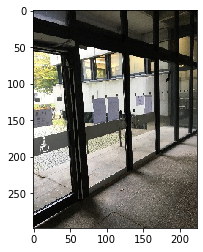

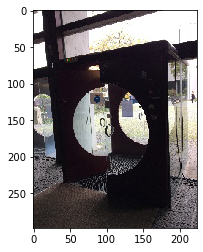

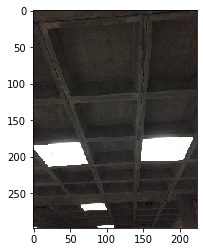

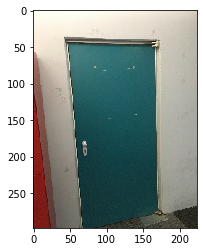

In [19]:
import matplotlib.pyplot as plt

images_investigate = [0, 9, 110, 152]
for im_id in images_investigate:
    plt.imshow(X_test[im_id])
    plt.show()

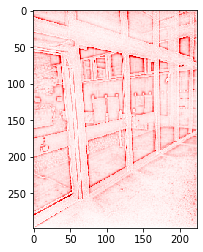

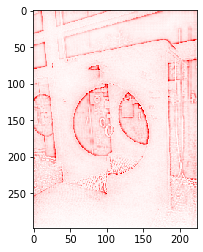

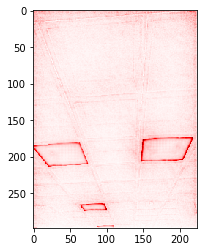

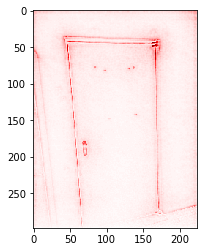

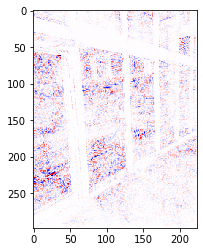

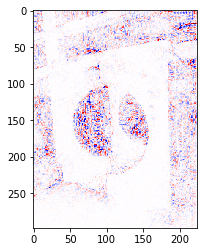

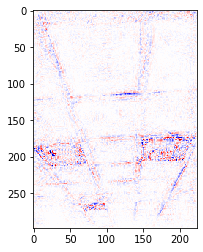

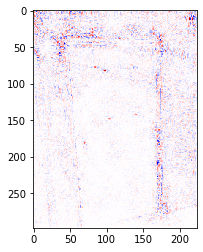

In [11]:
import matplotlib.pyplot as plt

images_investigate = [0, 9, 110, 152]

analyzers = ['deep_taylor', 'lrp.z']
for a in analyzers:
    model_analyzer = innvestigate.create_analyzer(a, keras_model)
    for im_id in images_investigate:
        image = X_test[im_id]
        image = np.expand_dims(image, axis=0)
        a = model_analyzer.analyze(image)
        a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
        a /= np.max(np.abs(a))
        # Plot
        a = np.squeeze(a)
        plt.imshow(a, cmap="seismic", clim=(-1, 1))
        plt.show()